#### <b>Download the Original Datasets</b>

The Japanese Female Facial Expression (JAFFE) Dataset


Authors: Lyons, Michael; Kamachi, Miyuki;  Gyoba, Jiro

Specifications:

10 Japanese female expressers

7 Posed Facial Expressions (6 basic facial expressions + 1 neutral)

Several images of each expression for each expresser 

213 images total

Each image has averaged semantic ratings on 6 facial expressions by 60 Japanese viewers

Resolution 256x256 pixels

8-bit grayscale;; Tiff format, no compression

The image dataset was planned and assembled by Michael Lyons, Miyuki Kamachi, and Jiro Gyoba, at Kyushu University, Japan.

"The JAFFE images may be used for non-commercial scientific research under certain terms of use, which must be accepted to access the data."

"The following article describes the JAFFE images and how they were photographed:
Michael J. Lyons, Miyuki Kamachi, Jiro Gyoba."

https://zenodo.org/record/3451524#.YcSqWmDMK3A

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [279]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

In [280]:
path = "./Japanese_Female_Facial_Expressions/"

In [281]:
image_paths = []
labels = []

for filename in os.listdir(path):
    if filename.endswith(".tiff"):
        image_paths.append(os.path.join(path, filename))
        label = filename[3:5]
        labels.append(label)

# Chia dữ liệu thành tập train và test (80% train, 20% test)
image_paths_train, image_paths_temp, labels_train, labels_temp = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Chia tập còn lại thành tập test và unseen (50% test, 50% unseen của tập temp)
image_paths_test, image_paths_unseen, labels_test, labels_unseen = train_test_split(
    image_paths_temp, labels_temp, test_size=0.75, stratify=labels_temp, random_state=42
)

print("Số lượng ảnh trong tập train:", len(image_paths_train))
print("Số lượng ảnh trong tập test:", len(image_paths_test))
print("Số lượng ảnh trong tập unseen:", len(image_paths_unseen))

Số lượng ảnh trong tập train: 149
Số lượng ảnh trong tập test: 16
Số lượng ảnh trong tập unseen: 48


In [282]:
expression_class_to_label = {
    "AN": 0, "DI": 1, "FE": 2, "HA": 3, "NE": 4, "SA": 5, "SU": 6
}

In [283]:
train_set = [[image_path, torch.tensor(expression_class_to_label[label], dtype=torch.long)] for image_path, label in zip(image_paths_train, labels_train)]
test_set = [[image_path, torch.tensor(expression_class_to_label[label], dtype=torch.long)] for image_path, label in zip(image_paths_test, labels_test)]
unseen_set = [[image_path, torch.tensor(expression_class_to_label[label], dtype=torch.long)] for image_path, label in zip(image_paths_unseen, labels_unseen)]

In [284]:
class Dataset(Dataset):
    def __init__(self, image_expression_list, transform=None, forget=False, retrain=False):
        self.transform = transform
        self.image_expression_list = image_expression_list

        if forget:
            self.image_expression_list = self.image_expression_list[0:24]
        if retrain:
            self.image_expression_list = self.image_expression_list[24:]

    def __len__(self):
        return len(self.image_expression_list)

    def __getitem__(self, idx):
        image_path, label = self.image_expression_list[idx]
        img = Image.open(image_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [285]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

In [286]:
train_dataset = Dataset(train_set, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = Dataset(test_set, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Chia tập còn lại thành tập test và unseen (50% test, 50% unseen của tập temp)
image_paths_unseen_test, image_paths_unseen_train, labels_unseen_test, labels_unseen_train = train_test_split(
    image_paths_unseen, labels_unseen, test_size=0.5, stratify=labels_unseen, random_state=42
)
unseen_train_set = [[image_path, torch.tensor(expression_class_to_label[label], dtype=torch.long)] for image_path, label in zip(image_paths_unseen_train, labels_unseen_train)]
unseen_test_set = [[image_path, torch.tensor(expression_class_to_label[label], dtype=torch.long)] for image_path, label in zip(image_paths_unseen_test, labels_unseen_test)]

unseen_dataset_train = Dataset(unseen_train_set, unseen_transform)
unseen_dataloader_train = DataLoader(unseen_dataset_train, batch_size=8, shuffle=False)

unseen_dataset_test = Dataset(unseen_test_set, unseen_transform)
unseen_dataloader_test = DataLoader(unseen_dataset_test, batch_size=8, shuffle=False)

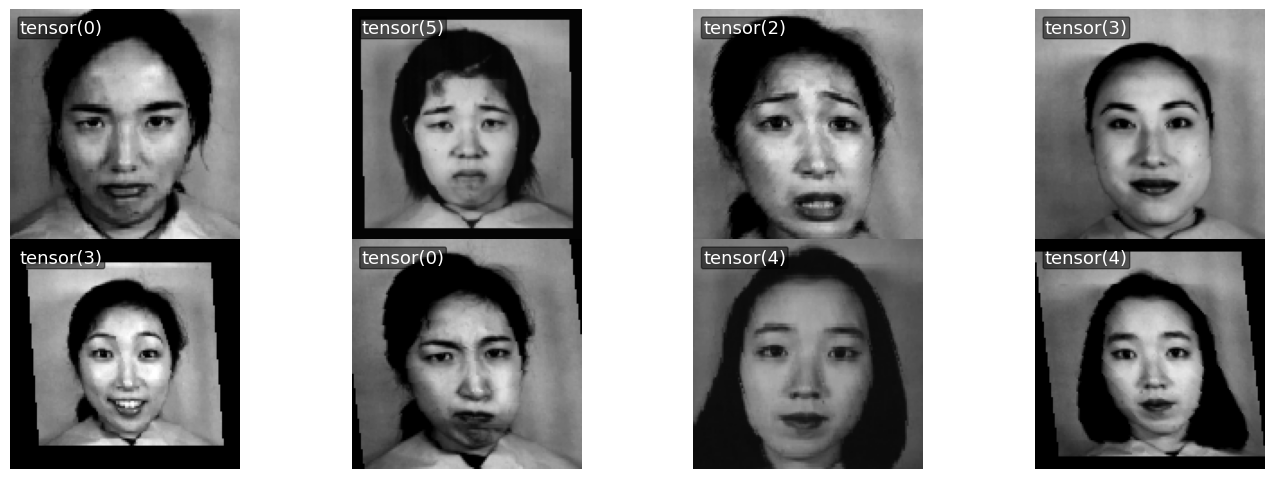

In [287]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        
        img_np = img.numpy().transpose((1, 2, 0))  
        
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13, ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

# Lấy batch từ DataLoader
iterator = iter(train_dataloader)
imgs, labels = next(iterator)

# Nếu labels là chuỗi, trực tiếp sử dụng label
label_strs = [label for label in labels[0:8]]  # Dùng trực tiếp giá trị label nếu là chuỗi

# Hiển thị ảnh và nhãn
show_images(imgs[0:8], label_strs, nrow=4)


In [311]:
forget_dataset_train = Dataset(train_set, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=8, shuffle=False)

retrain_dataset = Dataset(train_set, train_transform, retrain=True)
retrain_dataloader = DataLoader(retrain_dataset, batch_size=8, shuffle=True)

forget_dataset_test = Dataset(train_set, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=8, shuffle=False)

In [312]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('retrain dataset size:', len(retrain_dataset))
print('Unseen dataset size:', len(unseen_dataset_train))

Train dataset size: 149
Test dataset size: 16
Forget dataset size: 24
retrain dataset size: 125
Unseen dataset size: 24


In [290]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [291]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []
    net.eval()
    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            logits = net(inputs)
            losses = criterion(logits, targets).cpu().detach().numpy()
            
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=42):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model, unseen_dataloader_test):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader_test)

    np.random.shuffle(forget_losses)
    np.random.shuffle(unseen_losses)
    unseen_losses = unseen_losses[: len(forget_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)
  
    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [292]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [293]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
 
        imgs, labels = batch
    
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [294]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_original_epochs = 100
best_test_acc = 0
best_epoch = 0

In [ ]:
history = []
accuracy = []
for epoch in range(num_original_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    test_loss, test_acc = test()
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_NEW_DATASET_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_NEW_DATASET_checkpoint_epoch_{num_original_epochs}.pth')

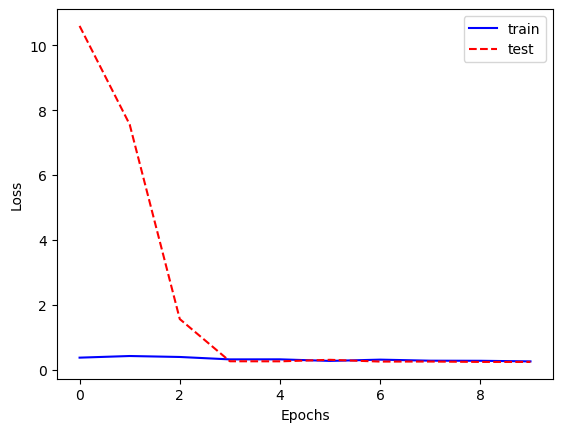

In [ ]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='test') 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

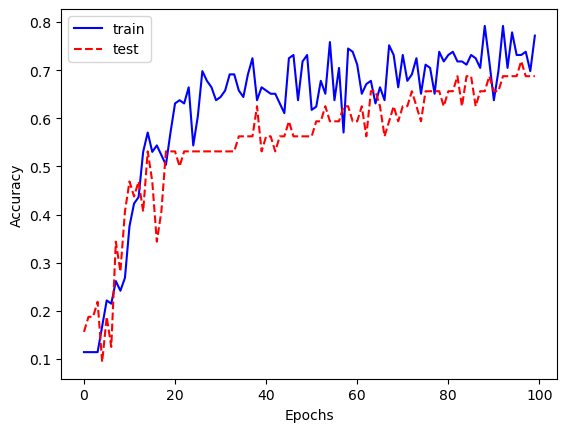

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Stage 1: Forgetting via PIU-FR

In [295]:
random.seed(42)

In [296]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'best_NEW_DATASET_checkpoint_epoch_97.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 7)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

In [317]:
# Performance
log_step = 30
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader_test)
mia = cal_mia(original_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.09375029057264328, running test accuracy: 0.75, running top-2 accuracy: 0.875
test loss: 0.0879705362021923, accuracy: 0.75, top-2 accuracy: 0.875
elapsed time: 0.21670818328857422
[Test]
[Batch: 1] running test loss: 0.07322635501623154, running test accuracy: 0.75, running top-2 accuracy: 1.0
test loss: 0.10814625521500905, accuracy: 0.625, top-2 accuracy: 0.875
elapsed time: 0.10256171226501465
Test Acc: {'Loss': 0.0879705362021923, 'Acc': 0.75, 'Top-2 Acc': 0.875}
Unseen Acc: {'Loss': 0.10814625521500905, 'Acc': 0.625, 'Top-2 Acc': 0.875}
MIA: {'MIA': 0.5999999999999999, 'Forgeting Score': 0.09999999999999987}
Final Score: 0.7750000000000001


In [328]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'best_NEW_DATASET_checkpoint_epoch_97.pth'
forgot_model = models.resnet18(pretrained=False)
num_features = forgot_model.fc.in_features
forgot_model.fc = nn.Linear(num_features, 7)
forgot_model.load_state_dict(torch.load(original_save_path))
forgot_model = forgot_model.cuda()
criterion = nn.CrossEntropyLoss()

In [299]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [300]:
class New_Unseen_Dataset(Dataset):
    def __init__(self, image_expression_list, transform=None, forget_dataloader=None):
        self.transform = transform
        self.image_expression_list = image_expression_list
        self.forget_dataloader = forget_dataloader

        new_image_expression_list = []
        
        dict_image_lists = {}
        for image_path, expression_class in image_expression_list:
            if expression_class not in dict_image_lists:
                dict_image_lists[int(expression_class)] = [[image_path, expression_class]]
            else:
                dict_image_lists[int(expression_class)].append([image_path, expression_class])

        for inputs_forget, labels_forget in forget_dataloader:
            labels_forget = labels_forget  # Convert to numpy array for easier handling
            
            for label in labels_forget:
                same_class_samples = dict_image_lists[int(label)]
                
                if same_class_samples:
                    chosen_sample = random.choice(same_class_samples)
                    new_image_expression_list.append(chosen_sample)
        
        self.image_expression_list = new_image_expression_list

    def __len__(self):
        return len(self.image_expression_list)

    def __getitem__(self, idx):
        image_path, label = self.image_expression_list[idx]
        img = Image.open(image_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label   

In [ ]:
class PIU_FR:
    def __init__(self, original_model, forgot_model, forget_dataloader):
        self.original_model = original_model
        self.forgot_model = forgot_model
        self.forget_dataloader = forget_dataloader
        #self.retrain_dataloader = retrain_dataloader
        self.criterion_div = DistillKL(4.0)
        self.optimizer = optim.SGD(self.forgot_model.parameters(), lr=0.001)
        self.criterion = torch.nn.CrossEntropyLoss()

    def train_epoch(self):
        set_seed(42)
        self.forgot_model.train()
        self.original_model.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_div, total_accuracy_forget = 0, 0
        
        # Process new unseen_dataloader
        new_unseen_dataset = New_Unseen_Dataset(unseen_train_set, unseen_transform,  self.forget_dataloader)
        new_unseen_dataloader = DataLoader(new_unseen_dataset, batch_size=8, shuffle=False)

        # Training with unseen data.
        flag = 1

        for (inputs_unseen, labels_unseen), (inputs_forget, labels_forget) in zip(new_unseen_dataloader, self.forget_dataloader):
            inputs_unseen, labels_unseen = inputs_unseen.cuda(), labels_unseen.cuda()
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            outputs_forget = self.forgot_model(inputs_forget)

            with torch.no_grad():
                outputs_unseen = self.original_model(inputs_unseen)

            # Loss computation
            loss_div = flag * self.criterion_div(outputs_forget, outputs_unseen)

            # Update total loss and accuracy for unseen data.
            total_loss_div += loss_div.item()
            total_accuracy_forget += compute_accuracy(outputs_forget, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div.backward()
            self.optimizer.step()
            
            if flag == 1:
                flag = -1
            else:
                flag = 1

        # Print average loss and accuracy for the entire epoch
        avg_loss_div = total_loss_div / len(self.forget_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        mia = cal_mia(self.forgot_model.cuda(), unseen_dataloader_test)

        print(f'Epoch unseen: Avg Loss: {avg_loss_div:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}, Forgeting Score: {mia["Forgeting Score"]}')

In [ ]:
set_seed(42)

# Initialize and train
forgetting_trainer = PIU_FR(original_model, forgot_model, forget_dataloader_train)

num_epochs = 1
for epoch in range(num_epochs):
    forgetting_trainer.train_epoch()
    print(f"Epoch {epoch+1} completed.")

Epoch unseen: Avg Loss: 1.3771, Avg Accuracy: 87.50, Forgeting Score: 0.040000000000000036
Epoch 1 completed.


In [330]:
# Performance
log_step = 30
test_acc = evaluation(forgot_model, test_dataloader)
unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
mia = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.09327337890863419, running test accuracy: 0.75, running top-2 accuracy: 1.0
test loss: 0.08727908506989479, accuracy: 0.75, top-2 accuracy: 0.9375
elapsed time: 0.1361382007598877
[Test]
[Batch: 1] running test loss: 0.08283548057079315, running test accuracy: 0.625, running top-2 accuracy: 0.875
test loss: 0.10574319213628769, accuracy: 0.5416666666666666, top-2 accuracy: 0.9166666666666666
elapsed time: 0.18934941291809082
Test Acc: {'Loss': 0.08727908506989479, 'Acc': 0.75, 'Top-2 Acc': 0.9375}
Unseen Acc: {'Loss': 0.10574319213628769, 'Acc': 0.5416666666666666, 'Top-2 Acc': 0.9166666666666666}
MIA: {'MIA': 0.54, 'Forgeting Score': 0.040000000000000036}
Final Score: 0.835


In [ ]:
torch.save(forgot_model.state_dict(), f'test_forget_model.pth')

In [ ]:
original_save_path = f'test_forget_model.pth'
forgot_model = models.resnet18(pretrained=False)
num_features = forgot_model.fc.in_features
forgot_model.fc = nn.Linear(num_features, 7)
forgot_model.load_state_dict(torch.load(original_save_path))
forgot_model = forgot_model.cuda()
criterion = nn.CrossEntropyLoss()

# Stage 2: Improve accuracy (Optional)

In [309]:
def train_model_using_only_retrain(model):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(retrain_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test_model(model):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()
    
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
num_epochs = 2
learning_rate = 0.01
log_step = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(forgot_model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(forgot_model)
    test_loss, test_acc = test_model(forgot_model)

In [ ]:
# Performance
log_step = 30
test_acc = evaluation(forgot_model, test_dataloader)
unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
mia = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

# Compare With Retrained Model

In [332]:
num_epochs = 100

retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 7)
retrained_model = retrained_model.cuda()
criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(retrained_model)
    test_loss, test_acc = test_model(retrained_model)

[Epoch: 1 - Training]
train loss: 0.33088130378723146, accuracy: 0.09600000083446503
elapsed time: 0.970012903213501
[Test]
[Batch: 1] running test loss: 2.478501319885254, running test accuracy: 0.125
test loss: 2.6000778675079346, accuracy: 0.0625
elapsed time: 0.06406831741333008
[Epoch: 2 - Training]
train loss: 0.49200311756134035, accuracy: 0.13600000739097595
elapsed time: 1.1221821308135986
[Test]
[Batch: 1] running test loss: 10.02354907989502, running test accuracy: 0.25
test loss: 14.569573879241943, accuracy: 0.1875
elapsed time: 0.05910801887512207
[Epoch: 3 - Training]
train loss: 0.37656359577178955, accuracy: 0.13600000739097595
elapsed time: 1.035029649734497
[Test]
[Batch: 1] running test loss: 0.33158084750175476, running test accuracy: 0.25
test loss: 0.6460258811712265, accuracy: 0.1875
elapsed time: 0.050591230392456055
[Epoch: 4 - Training]
train loss: 0.3314595069885254, accuracy: 0.18400001525878906
elapsed time: 0.9758305549621582
[Test]
[Batch: 1] running tes

In [333]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader_test)
mia = cal_mia(retrained_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print()
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.23937121033668518, running test accuracy: 0.125, running top-2 accuracy: 0.375
test loss: 0.22836802899837494, accuracy: 0.3125, top-2 accuracy: 0.4375
elapsed time: 0.06714487075805664
[Test]
[Batch: 1] running test loss: 0.23025918006896973, running test accuracy: 0.125, running top-2 accuracy: 0.375
test loss: 0.24072386821111044, accuracy: 0.16666666666666666, top-2 accuracy: 0.375
elapsed time: 0.1041419506072998
Test Acc: {'Loss': 0.22836802899837494, 'Acc': 0.3125, 'Top-2 Acc': 0.4375}
Unseen Acc: {'Loss': 0.24072386821111044, 'Acc': 0.16666666666666666, 'Top-2 Acc': 0.375}
MIA: {'MIA': 0.38, 'Forgeting Score': 0.12}

Final Score: 0.53625
